# Master's Thesis: Investigating Maximum Rainfall Trends in Colorado

<b>Institution:</b> University of Georgia <br>
<b>Department:</b> Statistics <br>
<b>Student:</b> Jeremy Mulcahey <br>
<b>Advisor:</b> Dr. Lynne Seymour <br>
<b>File:</b> 02_Boulder<br>
<b>Last Edit:</b> 7/4/2016

Section 0: Preparing data <br>
Section 1: Distribution of Max Precipitation and Trends<br>
Section 2: Parameter Estimation, Distribution, and Trends

##  Section 0: Preparing data

In [1]:
require(fitdistrplus); # required for parameter estimation
require(caTools);      # required for smoothing
require(repr);         # required for resizing plots in IRKernel
require("IRdisplay");  # graphic embedding
require(MASS);         # testing

Loading required package: fitdistrplus
Loading required package: MASS
Loading required package: survival
Loading required package: caTools
Loading required package: repr
Loading required package: IRdisplay


In [2]:
# establish working directorys
setwd("C:/Users/jerem/Desktop/UGA/Master'sThesis/")

Data files for individual station names.

In [3]:
data = read.csv(file = "data/FORT_MonMax_GHCN.csv", head=T)

Adjust the data for later use.

In [4]:
# Create an index as x - used as needed
month = seq(1,nrow(data),by=1)
data = cbind(data,month)

# first year of the data (changes by station name)
firstYear = data$YEAR[1]

# station name for plotting
stationName = as.character(data$STATION_NAME[1])

# -999 messed with the plotting - change to NA
data[data==-999] = NA

sum(is.na(data)) #print number of missing values

[1] 11

Check number of years in the data set.

In [5]:
data$YEAR[nrow(data)]-firstYear

[1] 118

In [6]:
table(data$MONTH)


  1   2   3   4   5   6   7   8   9  10  11  12 
119 119 119 119 119 119 119 119 119 119 119 119 

Make a data frame of all the 10 year periods following the first year for data collected at the station.

In [7]:
#create the first decade (first year and the following 9 years)
max_PRCP = data.frame(data[which(data$YEAR < (firstYear + 10)),6])

# add all the subsequent decades to the data frame incrementing by 1 year at a time
# i.e. 1896-1905, 1897-1906, etc
for(year in c((data$YEAR[1] + 1):2005)){
    max_PRCP = cbind(max_PRCP,data[which(data$YEAR >= year & data$YEAR < year+10),6])
}

# name the columns as the first year of the observed 10 year periods
colnames(max_PRCP) = as.character(c(firstYear:2005))

# set the missing values to NA
max_PRCP[max_PRCP==-999] = NA

## Section 1: Distribution of Max Precipitation and Trends

In [8]:
data2012 = data[which(data$YEAR<2013),]

In [58]:
options(repr.plot.width=5, repr.plot.height=5) #reduces the plot sizes

### Maximum Rainfall Trends

In [10]:
# create for maximum rainfall
maxTS = ts(data$Max.PRCP, start = firstYear, freq=12)

# create regression line
reg = lm(Max.PRCP. ~ month, data=data)

Slope of the regression line:

In [11]:
round(reg$coefficients[2],3)

month 
0.014

In [12]:
length(data$MONTH)*round(reg$coefficients[2],3)

month 
19.992

Although month isn't very predictive of maximum observed rainfall, there does appear to be an increase over the time data was collected.

In [13]:
maxTS2012 = ts(data2012$Max.PRCP, start = firstYear, freq=12)

In [14]:
maxObs = max(na.omit(data2012$Max.PRCP.))

In [15]:
smooth = runmean(data2012$Max.PRCP., 120)

In [16]:
smoothTS = ts(smooth, start=firstYear, freq=12)

In [17]:
which(data2012$Max.PRCP.==maxObs)

[1] 1219

In [18]:
data2012[1060,]

,STATION,STATION_NAME,YEAR,MONTH,Obs,Max.PRCP.,month
1060,GHCND:USC00053005,FORT COLLINS CO US,1984,4,30,516,1060


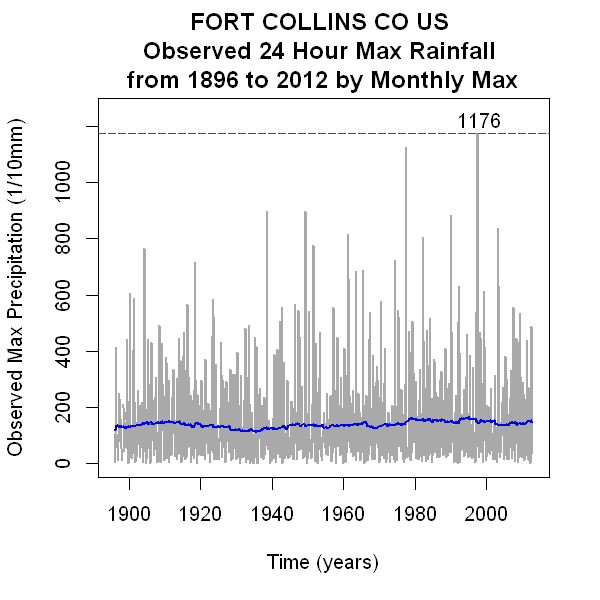

In [59]:
plot(maxTS2012, xlab = "Time (years)", col = "darkgrey", lwd=1.75, ylab = "Observed Max Precipitation (1/10mm)", 
     main=sprintf("%s \nObserved 24 Hour Max Rainfall \nfrom %i to 2012 by Monthly Max", 
     stationName,firstYear), ylim=c(0,1250))
abline(h=maxObs, col="red", lwd=.5, lty=5)
points(smoothTS, col=4, type="l", lwd=2)
text(1998,maxObs+50,
           sprintf("%i",maxObs))

In the time series plot, we also see that the peaks are gradually increasing over time, which is of specific interest to people working with maximum rainfall estimation. These increasing peaks have been wreaking havoc on Texas and the Eastern US this year. (Template statement - change as needed for individual stations).

Produce smoothed plots to get a better understanding of the trends.

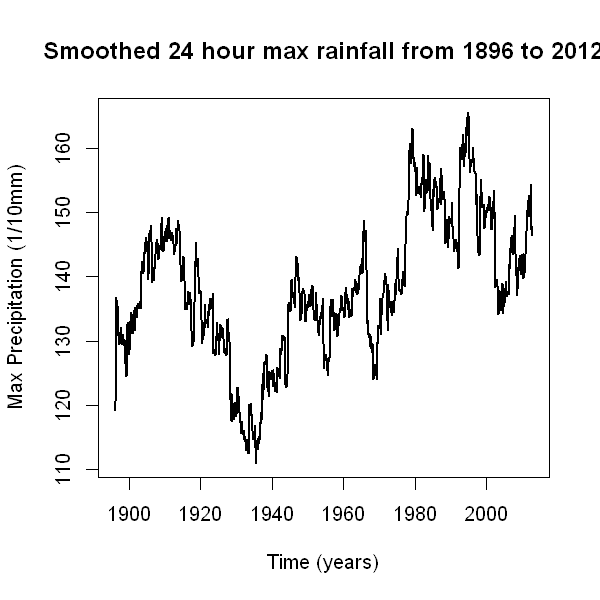

In [20]:
#rollSmall = runmean(data$Max.PRCP., 300)
plot(smoothTS, type="l", xlab = "Time (years)", lwd=2,
    ylab = "Max Precipitation (1/10mm)", col = 1, main="Smoothed 24 hour max rainfall from 1896 to 2012")
    #points(rollLarge, type="l", col=4)
    #egend(0,200, c("300 window","", "900 window"), col=c(2,0,4), lty=c(1,0,1), bty="n")

While the data shows a slight decrease in average rainfall at the tail end of our data (2014), the long term trend shows that average rainfall has been increasing. Empirically, we have had a wet year in 2016 that we would expect to match/exceed the long term observed increase in average maximum rainfall.(Template statement - change as needed for individual stations)

## Section 2: Parameter Estimation, Distribution, and Trends

In [21]:
mleGamma = data.frame(alpha = double(),
                 theta = double(),
                 KS = double(),
                 KStest = character(),
                 CvM = double(),
                 CvMtest = character(),
                 AD = double(),
                 ADtest = character(),
                 stringsAsFactors = FALSE)
                
for (i in 1:length(max_PRCP)) {

    testDist = na.omit(max_PRCP[,i])
        
        for(j in 1:length(testDist)){
            if(testDist[j] < .1){
            testDist[j]=.0001
            }
        }

   gamma1 = fitdist(as.vector(testDist),"gamma",method = "mle")
   mleGamma[i,1] = gamma1$estimate[1]
   mleGamma[i,2] = gamma1$estimate[2]
   
   gof = gofstat(gamma1)
   mleGamma[i,3] = gof$ks
   mleGamma[i,4] = gof$kstest
   mleGamma[i,5] = gof$cvm
   mleGamma[i,6] = gof$cvmtest
   mleGamma[i,7] = gof$ad
   mleGamma[i,8] = gof$adtest
}

mleGamma["invTheta"] = 1/(mleGamma$theta)
mleGamma["mean"] = mleGamma$invTheta*mleGamma$alpha
mleGamma["var"] = mleGamma$alpha*(mleGamma$invTheta^2)
mleGamma["sd"] = sqrt(mleGamma$var)

In [22]:
mleExp = data.frame(theta = double(),
                 KS = double(),
                 KStest = character(),
                 CvM = double(),
                 CvMtest = character(),
                 AD = double(),
                 ADtest = character(),
                 stringsAsFactors = FALSE)
                
for (i in 1:length(max_PRCP)) {

    testDist = na.omit(max_PRCP[,i])
        
        for(j in 1:length(testDist)){
            if(testDist[j] < .1){
            testDist[j]=.0001
            }
        }

   exp1 = fitdist(as.vector(testDist),"exp",method = "mle")
   mleExp[i,1] = exp1$estimate[1]
   
   gof = gofstat(exp1)
   mleExp[i,2] = gof$ks
   mleExp[i,3] = gof$kstest
   mleExp[i,4] = gof$cvm
   mleExp[i,5] = gof$cvmtest
   mleExp[i,6] = gof$ad
   mleExp[i,7] = gof$adtest
}

mleExp["mean"] = 1/mleExp$theta
mleExp["square"] = mleExp$theta^2 
mleExp["var"] = 1/mleExp$square
mleExp["sd"] = sqrt(mleExp$var)

In [23]:
which(mleGamma$KStest=="rejected")

[1] 30 31 32 33 34 35 36 37 38 39 52 53 54 55 56 57 61 62

In [24]:
which(mleExp$KStest=="rejected")

integer(0)

In [25]:
head(mleGamma)

alpha,theta,KS,KStest,CvM,CvMtest,AD,ADtest,invTheta,mean,var,sd
0.7702459,0.005838670,0.11823885,not rejected,0.3945848,NA,2.578290,NA,171.2719,131.9215,22594.44,150.3145
0.7592384,0.005623842,0.10957672,not rejected,0.3993983,NA,2.545615,NA,177.8144,135.0035,24005.57,154.9373
0.7329028,0.005426065,0.11023874,not rejected,0.3867091,NA,2.377635,NA,184.2956,135.0708,24892.95,157.7750
0.7228140,0.005126209,0.10648805,not rejected,0.3718661,NA,2.266249,NA,195.0759,141.0036,27506.41,165.8506
0.7894197,0.005429997,0.10174311,not rejected,0.2569872,NA,1.422317,NA,184.1622,145.3812,26773.72,163.6268
0.7953316,0.005407428,0.09718581,not rejected,0.2725329,NA,1.497542,NA,184.9308,147.0813,27199.86,164.9238


In [26]:
head(mleExp)

theta,KS,KStest,CvM,CvMtest,AD,ADtest,mean,square,var,sd
0.007582251,0.06135990,not rejected,0.07771479,not rejected,1.154525,not rejected,131.8870,5.749053e-05,17394.17,131.8870
0.007406461,0.05409077,not rejected,0.07202469,not rejected,1.120545,not rejected,135.0172,5.485567e-05,18229.66,135.0172
0.007404126,0.05999186,not rejected,0.06899385,not rejected,1.086094,not rejected,135.0598,5.482108e-05,18241.16,135.0598
0.007092198,0.05165822,not rejected,0.05439701,not rejected,1.053790,not rejected,141.0000,5.029928e-05,19881.00,141.0000
0.006879263,0.07186013,not rejected,0.08074364,not rejected,0.770200,not rejected,145.3644,4.732426e-05,21130.81,145.3644
0.006798410,0.06769829,not rejected,0.08938361,not rejected,0.817524,not rejected,147.0932,4.621838e-05,21636.42,147.0932


In [27]:
trueEst = NULL
for(i in 1:nrow(mleExp)){
    if(mleExp$KStest[i] == "not rejected" & mleGamma$KStest[i] == "not rejected"){
        trueEst = c(trueEst,"plot")
    }
    if(mleExp$KStest[i] == "not rejected" & mleGamma$KStest[i] == "rejected"){
        trueEst = c(trueEst,"exp")
    }
    if(mleExp$KStest[i] == "rejected" & mleGamma$KStest[i] == "not rejected"){
        trueEst = c(trueEst,"gamma")
    }
    if(mleExp$KStest[i] == "rejected" & mleGamma$KStest[i] == "rejected"){
        trueEst = c(trueEst,"fail")
    }
}

In [28]:
table(trueEst)

trueEst
 exp plot 
  18   92 

In [29]:
which(trueEst=="fail")

integer(0)

In [30]:
which(trueEst=="plot")

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
[20]  20  21  22  23  24  25  26  27  28  29  40  41  42  43  44  45  46  47  48
[39]  49  50  51  58  59  60  63  64  65  66  67  68  69  70  71  72  73  74  75
[58]  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
[77]  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110

In [31]:
options(repr.plot.width=9, repr.plot.height=5) #reduces the plot sizes

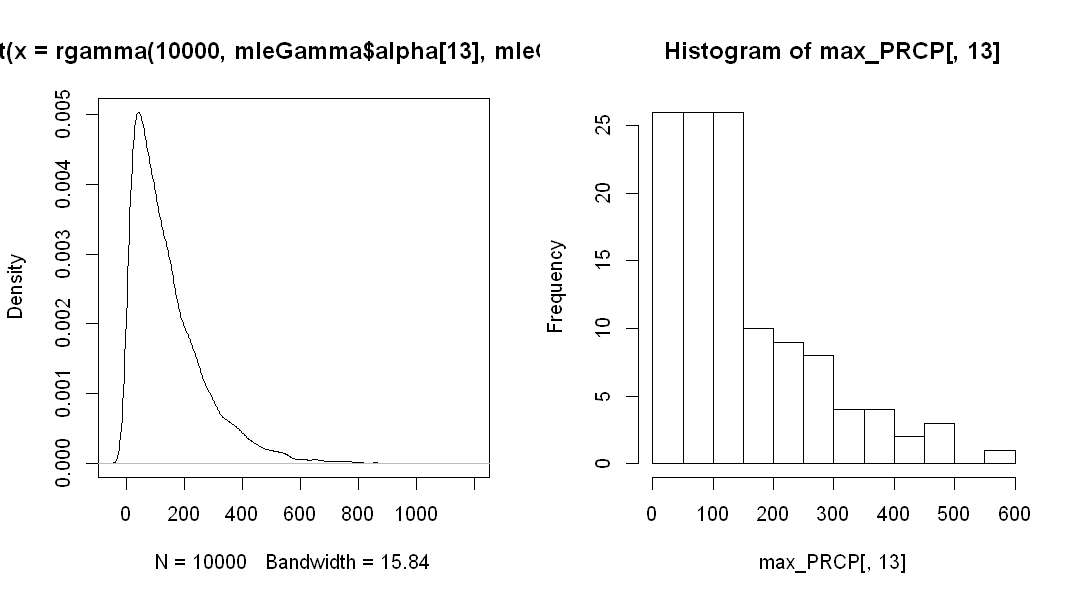

In [32]:
par(mfrow=c(1,2))
plot(density(rgamma(10000,mleGamma$alpha[13],mleGamma$theta[13])))
hist(max_PRCP[,13], breaks=20)

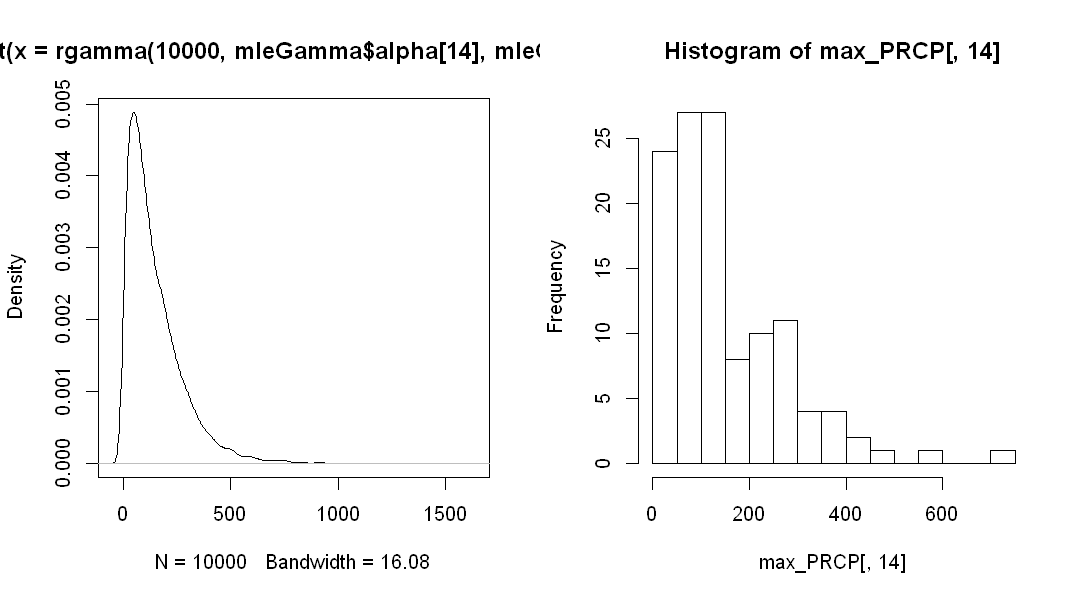

In [33]:
par(mfrow=c(1,2))
plot(density(rgamma(10000,mleGamma$alpha[14],mleGamma$theta[14])))
hist(max_PRCP[,14], breaks=20)

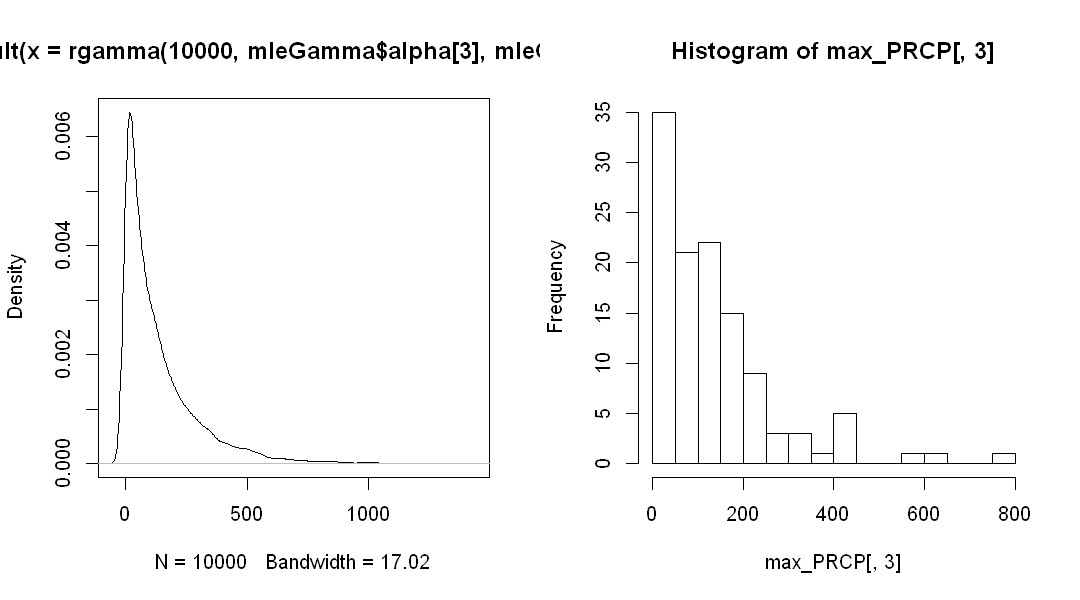

In [34]:
par(mfrow=c(1,2))
plot(density(rgamma(10000,mleGamma$alpha[3],mleGamma$theta[3])))
hist(max_PRCP[,3], breaks=20)

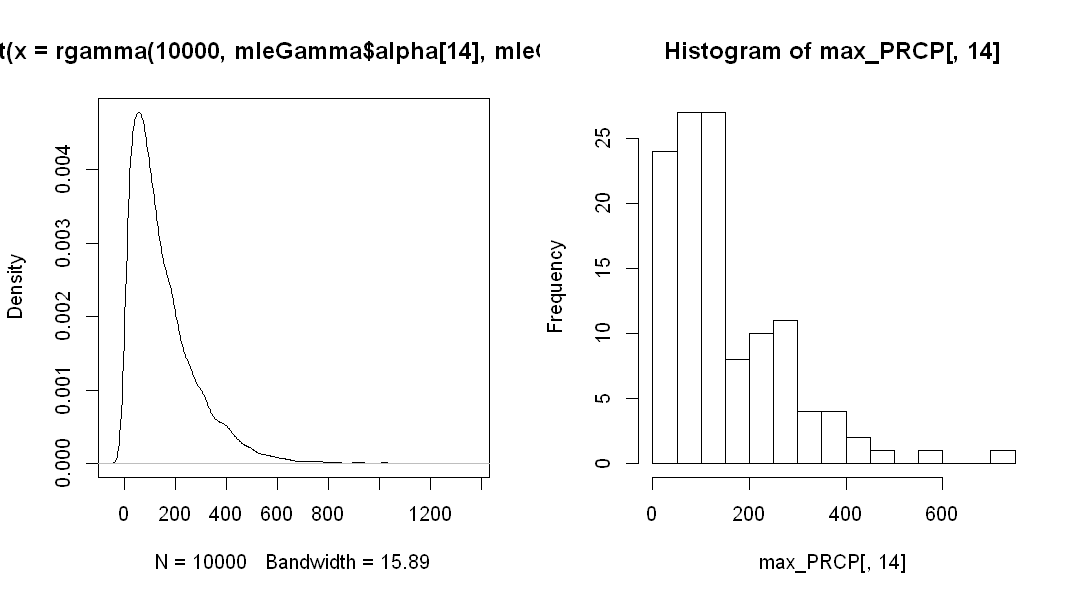

In [35]:
par(mfrow=c(1,2))
plot(density(rgamma(10000,mleGamma$alpha[14],mleGamma$theta[14])))
hist(max_PRCP[,14], breaks=20)

In [36]:
length(trueEst)

[1] 110

In [37]:
maxObs2 = max(na.omit(data$Max.PRCP.))

In [38]:
smooth2 = runmean(data$Max.PRCP., 120)

In [39]:
smoothTS2 = ts(smooth2, start=firstYear, freq=12)

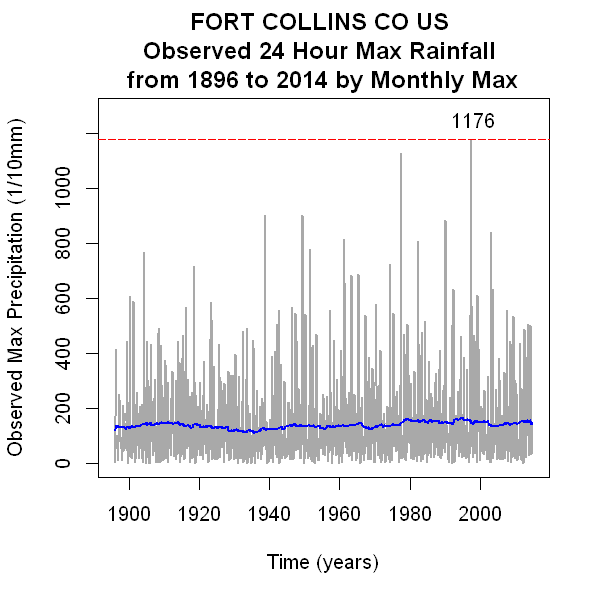

In [68]:
plot(maxTS, xlab = "Time (years)", col = "darkgrey", lwd=1.75, ylab = "Observed Max Precipitation (1/10mm)", 
     main=sprintf("%s \nObserved 24 Hour Max Rainfall \nfrom %i to 2014 by Monthly Max", 
     stationName,firstYear),ylim=c(0,1275))
abline(h=maxObs2, col="red", lwd=.5, lty=5)
points(smoothTS2, col=4, type="l", lwd=2)
text(1998,maxObs2+75,sprintf("%i",maxObs2))

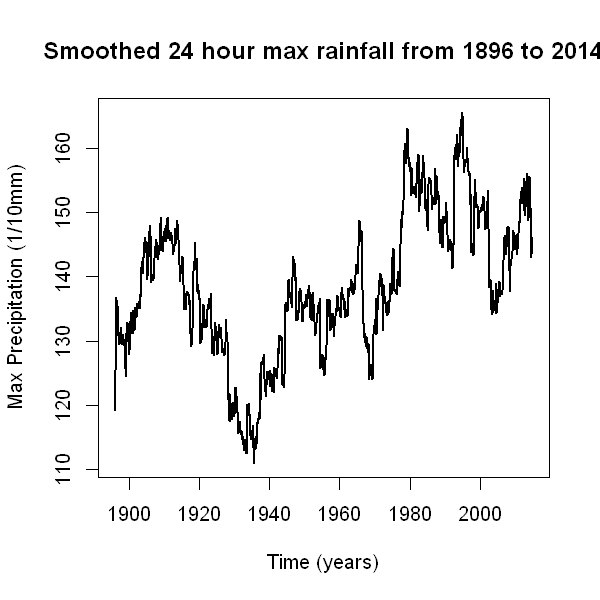

In [64]:
#rollSmall = runmean(data$Max.PRCP., 300)
plot(smoothTS2, type="l", xlab = "Time (years)", lwd=2,
    ylab = "Max Precipitation (1/10mm)", col = 1, main="Smoothed 24 hour max rainfall from 1896 to 2014")

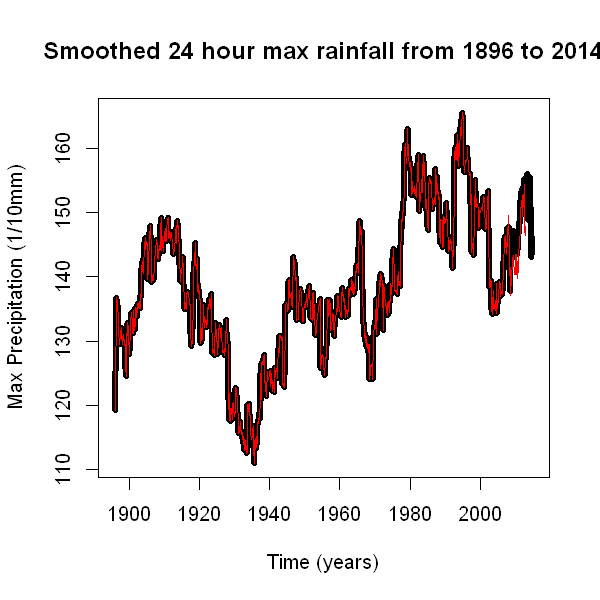

In [65]:
#rollSmall = runmean(data$Max.PRCP., 300)
plot(smoothTS2, type="l", xlab = "Time (years)", lwd=5,
    ylab = "Max Precipitation (1/10mm)", col = 1, main="Smoothed 24 hour max rainfall from 1896 to 2014")
lines(smoothTS, col=2)

In [43]:
monthly = NULL
for(i in 1:12){
    monthly = cbind(monthly,data2012[which(data2012$MONTH==i),"Max.PRCP."])
}
monthlyDF = as.data.frame(monthly)

In [44]:
colnames(monthlyDF) = c("jan", "feb","mar","apr","may","june","july","aug","sept","oct","nov","dec")

In [45]:
options(repr.plot.width=8, repr.plot.height=8) #reduces the plot sizes

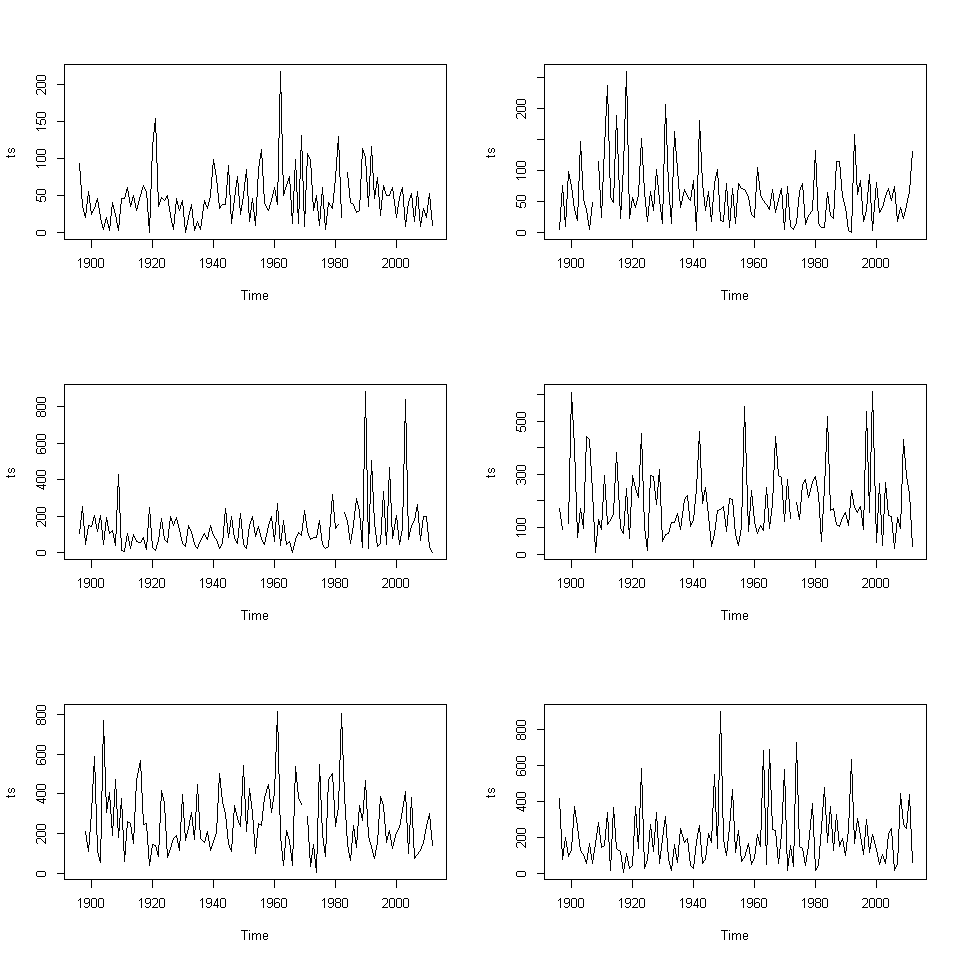

In [46]:
par(mfrow=c(3,2))
for(i in 1:6){
    ts = ts(monthlyDF[,i], start=firstYear)
    plot(ts)
}

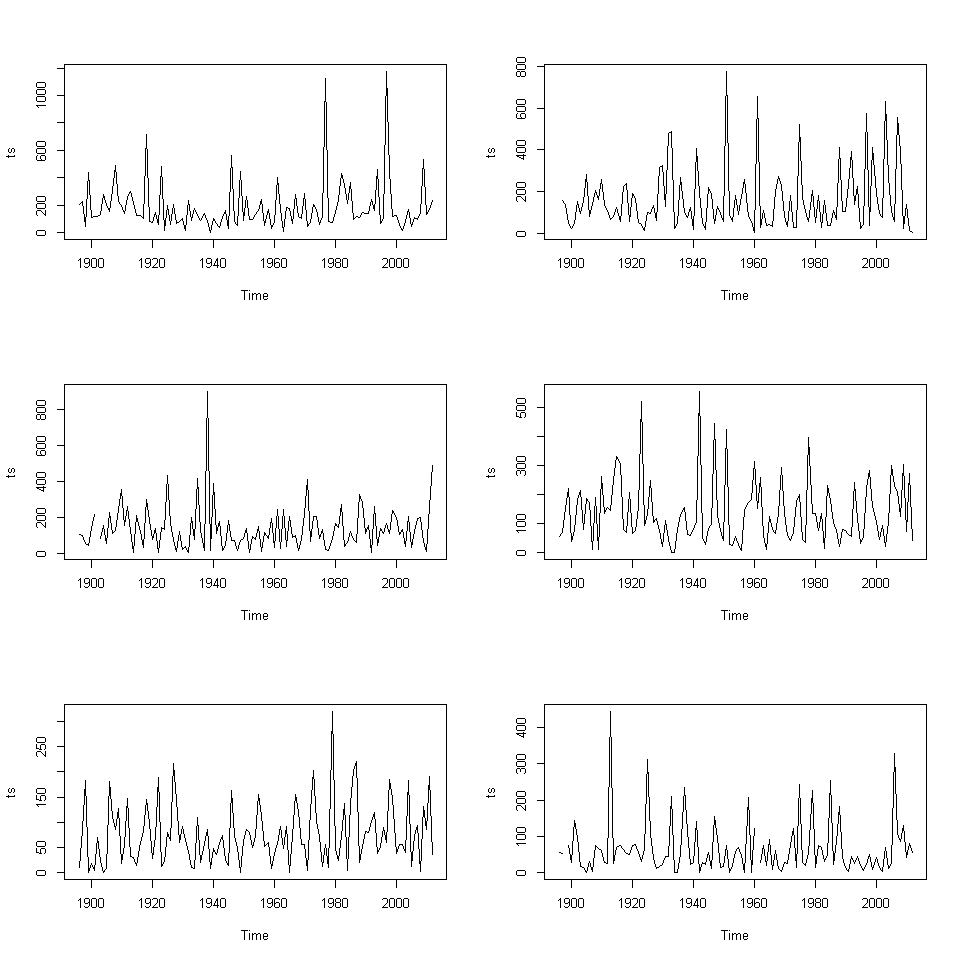

In [47]:
par(mfrow=c(3,2))
for(i in 7:12){
    ts = ts(monthlyDF[,i],start=firstYear)
    plot(ts)
}

In [48]:
means = apply(max_PRCP,2,mean)

In [49]:
sum(is.na(max_PRCP))

[1] 76

Can't use the apply function with all the NAs

In [50]:
means = NULL
for(i in 1:ncol(max_PRCP)){
    means = c(means,mean(na.omit(max_PRCP[,i])))
}

In [51]:
meanTS = ts(means,start=firstYear)

In [52]:
length(meanTS)

[1] 110

In [53]:
length(smoothTS2)

[1] 1428

In [54]:
objects()

[1] "data"        "data2012"    "exp1"        "firstYear"   "gamma1"     
 [6] "gof"         "i"           "j"           "max_PRCP"    "maxObs"     
[11] "maxObs2"     "maxTS"       "maxTS2012"   "means"       "meanTS"     
[16] "mleExp"      "mleGamma"    "month"       "monthly"     "monthlyDF"  
[21] "reg"         "smooth"      "smooth2"     "smoothTS"    "smoothTS2"  
[26] "stationName" "testDist"    "trueEst"     "ts"          "year"